In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/rsmac/.virtualenvs/EnginBnMac/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
[nltk_data] Downloading package stopwords to /Users/rsmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
df = pd.read_csv('cleaned_dataset.csv')

In [44]:
df['rating_class'] = df['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)
X = df['clean_text']
y = df['rating_class']

In [45]:
df['clean_text'][:4]

0    choose one product take care face rest life wo...
1    make skin lovely smooth woman near need help g...
2    work well reasonable price use regenerating se...
3    work lady try many product totally disappointe...
Name: clean_text, dtype: object

# Tokenizer

In [47]:
from keras.preprocessing.text import Tokenizer

samples = X
tokenizer = Tokenizer(lower=True, split=' ') # creates tokenizer
tokenizer.fit_on_texts(samples)  # builds the word index
sequences = tokenizer.texts_to_sequences(samples) #turns strings into list of integers
# word_index is a dictionary mapping words to an integer index
word_index = tokenizer.word_index 
print(f'Found {len(word_index)} unique tokens. ')

Found 25026 unique tokens. 


In [6]:
max([max(sequence) for sequence in sequences])

25026

In [7]:
# Each number is the index of the word in the order of word in original text
sequences[0]

[688,
 17,
 4,
 65,
 119,
 23,
 624,
 514,
 16,
 76,
 7357,
 76,
 545,
 5,
 110,
 1121,
 5,
 950,
 710,
 38,
 11,
 31,
 1,
 7,
 76,
 596,
 2800,
 76,
 82,
 118,
 213,
 130,
 70,
 880,
 546,
 3,
 5,
 330,
 100,
 43,
 1,
 524,
 30,
 21,
 293,
 3211,
 862,
 35,
 34,
 120,
 89,
 163,
 76,
 146,
 83,
 462,
 5,
 11,
 20,
 324,
 1,
 10,
 97,
 853,
 210,
 133,
 5,
 3,
 76,
 6409,
 990,
 6410,
 412,
 17,
 216,
 886,
 1,
 7,
 17,
 17,
 343,
 173,
 2519,
 7,
 225,
 235,
 164,
 4,
 45,
 2498,
 1765,
 9,
 1121,
 42,
 688,
 17,
 23,
 77,
 624,
 514,
 16,
 1023]

In [8]:
word_index

{'not': 1,
 'hair': 2,
 'use': 3,
 'product': 4,
 'skin': 5,
 'like': 6,
 'good': 7,
 'feel': 8,
 'great': 9,
 'get': 10,
 'work': 11,
 'dry': 12,
 'make': 13,
 'shampoo': 14,
 'look': 15,
 'would': 16,
 'one': 17,
 'really': 18,
 'smell': 19,
 'well': 20,
 'try': 21,
 'love': 22,
 'face': 23,
 'conditioner': 24,
 'scent': 25,
 'leave': 26,
 'nice': 27,
 'go': 28,
 'no': 29,
 'also': 30,
 'day': 31,
 'time': 32,
 'oil': 33,
 'much': 34,
 'little': 35,
 'wash': 36,
 'clean': 37,
 'long': 38,
 'soft': 39,
 'say': 40,
 'think': 41,
 'give': 42,
 'smooth': 43,
 'even': 44,
 'find': 45,
 'cream': 46,
 'need': 47,
 'light': 48,
 'recommend': 49,
 'apply': 50,
 'seem': 51,
 'color': 52,
 'see': 53,
 'lotion': 54,
 'way': 55,
 'easy': 56,
 'bottle': 57,
 'bit': 58,
 'help': 59,
 'first': 60,
 'eye': 61,
 'come': 62,
 'body': 63,
 'without': 64,
 'take': 65,
 'price': 66,
 'hand': 67,
 'thick': 68,
 'want': 69,
 'result': 70,
 'fine': 71,
 'keep': 72,
 'week': 73,
 'lot': 74,
 'may': 75,
 'seru

In [48]:
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in sequences[0]])

In [49]:
def sequence_to_text(sequence):
    words =  [reverse_word_index.get(letter) for letter in sequence]
    return words

my_text = list(map(sequence_to_text, sequences))


In [50]:
print(sequences[0])

[688, 17, 4, 65, 119, 23, 624, 514, 16, 76, 7357, 76, 545, 5, 110, 1121, 5, 950, 710, 38, 11, 31, 1, 7, 76, 596, 2800, 76, 82, 118, 213, 130, 70, 880, 546, 3, 5, 330, 100, 43, 1, 524, 30, 21, 293, 3211, 862, 35, 34, 120, 89, 163, 76, 146, 83, 462, 5, 11, 20, 324, 1, 10, 97, 853, 210, 133, 5, 3, 76, 6409, 990, 6410, 412, 17, 216, 886, 1, 7, 17, 17, 343, 173, 2519, 7, 225, 235, 164, 4, 45, 2498, 1765, 9, 1121, 42, 688, 17, 23, 77, 624, 514, 16, 1023]


# Word2Vec and Simple Neural Network

In [55]:
word2vec = gensim.models.Word2Vec(my_text,
                                  size=100,
                                  window=10,
                                  min_count=1)
word2vec.train(my_text, total_examples=25026, epochs=10)

(14200096, 17064580)

In [56]:
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                  for search_term in ['feel', 'good', 'product', 'cheap', 'beauty', 'bad', 'skin','fragrance']}
similar_words

{'feel': ['feeling', 'afterwards', 'film', 'hydrated', 'perfune'],
 'good': ['decent', 'great', 'nice', 'like', 'okay'],
 'product': ['products', 'brand', 'adovia', 'however', 'ethnicity'],
 'cheap': ['drugstore', 'walmart', 'afford', 'expensive', 'fancy'],
 'beauty': ['arsenal', 'multi', 'skincare', 'sybaritic', 'regime'],
 'bad': ['terrible', 'horrible', 'stink', 'awful', 'complain'],
 'skin': ['face', 'complexion', 'facial', 'breakout', 'redness'],
 'fragrance': ['scent', 'aroma', 'odor', 'perfume', 'smell']}

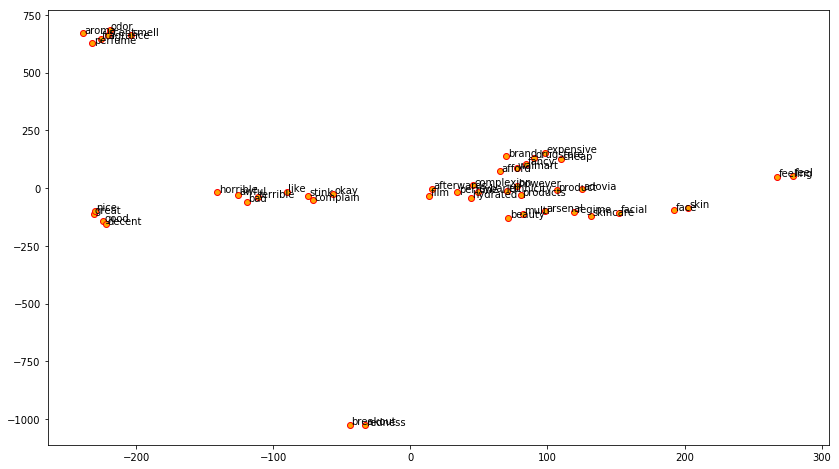

In [57]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')

In [58]:
len(word_index.keys())

25026

In [59]:
len(word2vec.wv.vocab)

25026

So we created word vectors using Word2Vec and the model has 25026 unique words where each word has a vector length of 100


Now we are going to use these dense vectors - word embeddings - in a simple neural network to predict 

In [60]:
from keras.preprocessing.sequence import pad_sequences
max_length = 200 # fix the length of each review 
max_words = len(word_index.keys()) # fix number of words 

training_samples = 15000
validation_samples = 9509
data = pad_sequences(sequences, maxlen=max_length)

#labels = np.asarray(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

x_train = data[:training_samples]
y_train = y[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = y[training_samples: training_samples + validation_samples]
print('Shape of training data: ', x_train.shape)
print('Shape of validation data: ', x_val.shape)

Shape of data tensor: (24509, 200)
Shape of label tensor: (24509,)
Shape of training data:  (15000, 200)
Shape of validation data:  (9509, 200)


In [61]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words+1, embedding_dim))
for word , i in word_index.items():
    embedding_vector = word2vec.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

The Embedding layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

The Embedding layer takes as input a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer

When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just like with any other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for.

In [62]:
embedding_matrix.shape

(25027, 100)

In [63]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


model = Sequential()
model.add(Embedding(max_words+1, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2502700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,142,765
Trainable params: 3,142,765
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [65]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 9509 samples
Epoch 1/10
15000/15000 [==============================] - 3s 176us/step - loss: 0.3634 - acc: 0.9043 - val_loss: 0.3025 - val_acc: 0.9275
Epoch 2/10
15000/15000 [==============================] - 2s 159us/step - loss: 0.2475 - acc: 0.9115 - val_loss: 0.3405 - val_acc: 0.9258
Epoch 3/10
15000/15000 [==============================] - 2s 159us/step - loss: 0.1643 - acc: 0.9341 - val_loss: 0.4079 - val_acc: 0.9067
Epoch 4/10
15000/15000 [==============================] - 2s 163us/step - loss: 0.0945 - acc: 0.9601 - val_loss: 0.5351 - val_acc: 0.9016
Epoch 5/10
15000/15000 [==============================] - 3s 209us/step - loss: 0.0522 - acc: 0.9800 - val_loss: 0.7162 - val_acc: 0.8817
Epoch 6/10
15000/15000 [==============================] - 3s 204us/step - loss: 0.0243 - acc: 0.9929 - val_loss: 0.8752 - val_acc: 0.8720
Epoch 7/10
15000/15000 [==============================] - 2s 165us/step - l

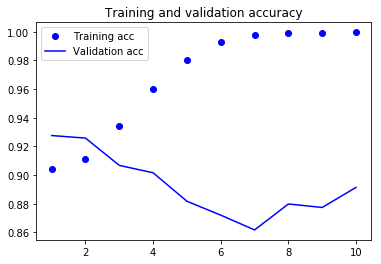

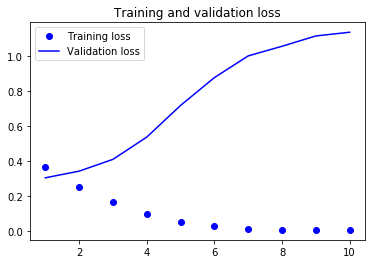

In [66]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s.